## 1.1 Preprocessing soil, fertilizers and yield variables

In [2]:
library("tidyverse")       # loads dplyr & ggplot2
library("robCompositions") # impCoda & impKNNa: for data imputation
library("compositions")    # for ILR transformations: acomp, ilr, ilrInv
library("zCompositions")   # cmultRepl(), reatment of Zeros, Left-Censored and Missing Values in Compositional Data Sets
select <- dplyr::select

Load the potato raw data frame __`Potato_df.csv`__.

In [2]:
data_df <- read.csv('data/Potato_df.csv')

### Arrange data table

Relevel preceding crop categories: __LRC__  as reference

In [3]:
data_df$PrecCropFiveClasses <- relevel(factor(data_df$PrecCropFiveClasses), ref = "LRC")

Choose cultivar __Superior__ as reference, it as the maximum number of samples in the data frame.

In [4]:
percentage <- round(with(data_df, prop.table(table(Cultivar)) * 100), 2)
distribution <- with(data_df, cbind(numHY = table(Cultivar), percent = percentage))

distribution <- data.frame(cbind(distribution, rownames(distribution)))
colnames(distribution)[3] <- "Cultivar"

distribution$numHY <- as.numeric(as.character(distribution$numHY)) # nHY = number of samples
distribution$percent <- as.numeric(as.character(distribution$percent)) # percentage
distribution %>% arrange(desc(numHY)) %>% head()

numHY,percent,Cultivar
<dbl>,<dbl>,<fct>
3108,24.03,Superior
1544,11.94,Kennebec
1420,10.98,Goldrush
1145,8.85,Shepody
989,7.65,Chieftain
686,5.30,FL 1207


In [5]:
data_df$Cultivar <-  relevel(factor(data_df$Cultivar), ref = "Superior")

Relevel maturity order __Maturity5__ in ascending order.

In [6]:
data_df$Maturity5 <- ordered(data_df$Maturity5, 
                             levels = c("early", "early mid-season", "mid-season", "mid-season late", "late"))

For soil texture categories, if sand content (__SableMesure__)  is missing (__NA__), replace it by the centroid of the textural category. Do the same for clay (__ArgileMesure__). Then, compute silt (__LimonMesure__) from clay  and sand.

In [7]:
data_df <- data_df %>%
  mutate(SableMesure = ifelse(is.na(SableMesure), SableCentroid, SableMesure)) %>%
  mutate(ArgileMesure = ifelse(is.na(ArgileMesure), ArgileCentroid, ArgileMesure))
data_df <- data_df %>% mutate(LimonDiff = 100 - SableMesure - ArgileMesure)

### Fertilization trials
Numerous informations are added, like minimal and maximal doses per trial, the number of doses as treatments, and the number of blocks per trial.

__Nitrogen__ trials

In [8]:
# Total N applied
tmpNsemisDose <- data_df$NsemisDose
tmpNfracDose <- data_df$NfracDose
tmpNsemisDose[is.na(data_df$NsemisDose)] <- 0
tmpNfracDose[is.na(data_df$NfracDose)] <- 0
data_df$NtotDose <- tmpNsemisDose + tmpNfracDose

In [9]:
# Maximal dose per trial
N_max.dose.trial <- data_df %>%
  group_by(NoEssai) %>%
  summarize(N_maxDoseTrial = max(NtotDose))
# minimal dose per trial
N_min.dose.trial <- data_df %>%
  group_by(NoEssai) %>%
  summarize(N_minDoseTrial = min(NtotDose))
# append to the data set
data_df <- left_join(data_df, N_max.dose.trial, 'NoEssai')
data_df <- left_join(data_df, N_min.dose.trial, 'NoEssai')

__Phosphorous__ trials: To compute indexes for phosphorus, the aluminum of the soil is considered since it's a fixative factor. `Al_total = Alsol + AlTabi`.

In [10]:
tmpAlSolTabi <- data_df$AlSolTabi
tmpAlSol <- data_df$AlSol
tmpAlSolTabi[is.na(data_df$AlSolTabi)] <- 0
tmpAlSol[is.na(data_df$AlSol)] <- 0
data_df$AlsoilTot <- tmpAlSolTabi + tmpAlSol # AlSolTot changed to AlsoilTot as in translate_col.csv file
data_df$AlsoilTot[data_df$AlsoilTot == 0] <- NA

In [11]:
P_max.dose.trial <- data_df %>%
  group_by(NoEssai) %>%
  summarize(P_maxDoseTrial = max(PtotDose))

P_min.dose.trial <- data_df %>%
  group_by(NoEssai) %>%
  summarize(P_minDoseTrial = min(PtotDose))

data_df <- left_join(data_df, P_max.dose.trial, 'NoEssai')
data_df <- left_join(data_df, P_min.dose.trial, 'NoEssai')

__Potassium__ trials

In [12]:
K_max.dose.trial <- data_df %>%
  group_by(NoEssai) %>%
  summarize(K_maxDoseTrial = max(KtotDose))

K_min.dose.trial <- data_df %>%
  group_by(NoEssai) %>%
  summarize(K_minDoseTrial = min(KtotDose))

data_df <- left_join(data_df, K_max.dose.trial, 'NoEssai')
data_df <- left_join(data_df, K_min.dose.trial, 'NoEssai')

This chain counts thes __number of doses__ per block.

In [13]:
nDose <- data_df %>%
  select(NoEssai, NoBloc, NtotDose) %>%
  group_by(NoEssai, NoBloc) %>%
  summarise(N_numDoseLevels = length(unique(NtotDose)))

pDose <- data_df %>%
  select(NoEssai, NoBloc, PtotDose) %>%
  group_by(NoEssai, NoBloc) %>%
  summarise(P_numDoseLevels = length(unique(PtotDose)))

kDose <- data_df %>%
  select(NoEssai, NoBloc, KtotDose) %>%
  group_by(NoEssai, NoBloc) %>%
  summarise(K_numDoseLevels = length(unique(KtotDose)))

data_df <- data_df %>% 
    left_join(nDose, by = c('NoEssai', 'NoBloc')) %>%
    left_join(pDose, by = c('NoEssai', 'NoBloc')) %>%
    left_join(kDose, by = c('NoEssai', 'NoBloc'))

... and this one counts the __number of blocks__ per trial.

In [14]:
nBloc <- data_df %>%
  select(one_of(c("NoEssai", "NoBloc"))) %>%
  group_by(NoEssai) %>%
  summarise(Bloc_numLevels = length(unique(NoBloc)))

data_df <- data_df %>% left_join(nBloc, by = c('NoEssai'))

This chain computes the __length of growing seasons__.

In [15]:
data_df$growing.season <- data_df$DOYrecolte - data_df$DOYplantation

### Soils data

__Soil elements__

Data imputation of soil analysis results. 
- Exclude "Bsol",  "CuSol", "ZnSol", and "MnSol" because too few data available
- no soil analysis data from Origine == "Inventaire provincial" and
- SourceProject == "Giroux, M. 1982. Can. J Soil Sc., 62: 503-517.".
- The imputation will be made by the mean of full data after imputation

In [16]:
keys_col <- c("NoEssai", "NoBloc", "NoTraitement")
soil_col <- c("CaSol", "MgSol", "Ksol", "FeSol", "AlsoilTot", "Psol") 
# AlSolTot changed to AlsoilTot to correspond with names in translate_col.csv file (later)

In [17]:
# Keep track of rows where soil analysis is empty
data_df$soilAnalysis_allNA <- apply(data_df[soil_col], 1, function(X) all(is.na(X)))
# Keep track of rows where soil analysis contains any NA
data_df$soilAnalysis_anyNA <- apply(data_df[soil_col], 1, function(X) any(is.na(X)))
# Number of NAs in soil data
data_df$soilAnalysis_countNA <- apply(data_df[soil_col], 1, function(X) sum(is.na(X)))
# There is 6 components. Not imputing more than half
data_df$soilAnalysis_hasTooMuchNA <- data_df$soilAnalysis_countNA > 3

Impute with kNN (robCompositions)

In [18]:
set.seed(23165)
soil_imputeElemRob <- impCoda(as.matrix(data_df[!data_df$soilAnalysis_hasTooMuchNA, soil_col]),
                              maxit = 10, 
                              eps = 0.5, 
                              method = "ltsReg",
                              closed = TRUE, 
                              init = "KNN", 
                              k = 10, 
                              noise = 0)
colnames(soil_imputeElemRob$xImp) <- paste0(soil_col, '_imp')

Push imputed soil elements into the main table

In [19]:
data_df <- left_join(x = data_df,
                     y = data.frame(NoEssai = data_df$NoEssai[!data_df$soilAnalysis_hasTooMuchNA],
                                    NoBloc = data_df$NoBloc[!data_df$soilAnalysis_hasTooMuchNA],
                                    NoTraitement = data_df$NoTraitement[!data_df$soilAnalysis_hasTooMuchNA],
                                    soil_imputeElemRob$xImp),
                     by = keys_col)

Add `environmental index`  __ISP1__ = P-m3 / Al-m3 with imputed elements

In [20]:
data_df <- data_df %>%
    mutate(ISP1 = Psol_imp * 100/ AlsoilTot_imp)

__Soil carbon__

In [21]:
data_df$Csol <- ifelse(data_df$MOouCtot == 'MO', 0.58*data_df$MOsol, data_df$MOsol)

__pH__

Convert `pH_CaCl2` to `pH_H2O`.

In [22]:
data_df$pH1dans1_H2O <- data_df$pH1dans1
pH_filter <- data_df$pHactifMethode == 'CaCl2' & !is.na(data_df$pH1dans1_H2O)
data_df$pH1dans1_H2O[pH_filter] <- 0.27 + 1.03 * data_df$pH1dans1[pH_filter]

Impute pH and soil carbon from soil analysis, but apart because the Aitchison metric is inappropriate

In [23]:
data_df$pHOM_allNA <- apply(data_df[c("pH1dans1_H2O", "Csol")], 1, function(X) all(is.na(X)))
data_df$pHOM_anyNA <- apply(data_df[c("pH1dans1_H2O", "Csol")], 1, function(X) any(is.na(X)))
data_df$pHOM_countNA <- apply(data_df[c("pH1dans1_H2O", "Csol")], 1, function(X) sum(is.na(X)))

In [24]:
data_impOMpH <- data_df %>%
                     select(one_of(c(keys_col, soil_col, "pH1dans1_H2O", "Csol"))) %>%
                     filter(!data_df$soilAnalysis_hasTooMuchNA, !data_df$pHOM_allNA)

In [25]:
# impute on log for Carbon
data_impOMpH[c(soil_col, 'Csol')] <- log10(data_impOMpH[c(soil_col, 'Csol')]) 
soil_imputeOMpHRob <- impKNNa(as.matrix(select(data_impOMpH, -one_of(keys_col))), 
                              metric = "Euclidean",
                              k = 6, primitive = TRUE,
                              normknn = TRUE, 
                              adj = 'median') # impute pH and C
soil_imputeOMpHRob$xImp[, 8] <- 10^soil_imputeOMpHRob$xImp[, 8] # C back to original scale

soilImputedOMpH <- as_tibble(data.frame(data_impOMpH[keys_col], soil_imputeOMpHRob$xImp[, c(7, 8)]))
colnames(soilImputedOMpH)[c(4, 5)] <- c("pH1dans1_H2O_imp", "Csol_imp")

Push to data_df

In [26]:
data_df <- left_join(x = data_df,
                     y = soilImputedOMpH,
                     by = keys_col)

### Soil types and composition balances computation
Custom functions are used for compositional data analysis.

In [27]:
source('https://raw.githubusercontent.com/essicolo/AgFun/master/ilrNA.R') # or source("lib/ilrNA.R")
source('https://raw.githubusercontent.com/essicolo/AgFun/master/ilrDefinition.R') # or source("lib/ilrDefinition.R")
source("https://raw.githubusercontent.com/essicolo/AgFun/master/codadend2.R") # source("lib/codadend2.R")

#### Soil textural balances

__Texture__: Transform texture proportions to balances: `[C | Mineral]`, `[Sand,Silt | Clay]`  and ` [Sand | Silt]` 

In [28]:
soilTextParts <- cbind(data_df$Csol_imp, 
                       (1-data_df$Csol_imp/100) * data_df[c('SableMesure','LimonDiff','ArgileMesure')])
soilTextComp <- acomp(soilTextParts)
soilTextSBP <- matrix(c(-1, 1, 1, 1,
                        0, 1, 1,-1,
                        0, 1,-1, 0),
                      byrow = TRUE,
                      ncol = 4)
soilTextBal <- ilr(soilTextComp, V = gsi.buildilrBase(t(soilTextSBP)))
soilTextBal <- ilrNA(soilTextComp, soilTextSBP, soilTextBal)

Store balances in the main data frame

In [29]:
data_df$soilTextIlr1 <- soilTextBal[, 1] # [C | Mineral]
data_df$soilTextIlr2 <- soilTextBal[, 2] # [Sand,Silt | Clay]
data_df$soilTextIlr3 <- soilTextBal[, 3] # [Sand | Silt]

#### Soil elements balances

In [30]:
# Compute the filling value
data_df$FvSol_imp <- 1e6 - rowSums(data_df[, paste0(soil_col, '_imp')])

Sequential binary partitions:

In [31]:
# Several SBPs embedded in a list
soilElemSBP <- list()

Classical soil analysis

In [32]:
soilElemSBP$all <- matrix(c( 1, 1, 1, 1, 1, 1,-1,
                             1, 1, 1,-1,-1,-1, 0,
                            -1,-1, 1, 0, 0, 0, 0, # balance [Ca,Mg | K] for response to K dose
                             1,-1, 0, 0, 0, 0, 0,
                             0, 0, 0, 1,-1,-1, 0,
                             0, 0, 0, 0,-1, 1, 0), # balance [Al | P] for response to P dose
                                            byrow = TRUE, ncol = 7)
colnames(soilElemSBP$all) <- c(soil_col, 'FvSol')

Phosphorous analysis 1

In [33]:
soilElemSBP$P1 <- matrix(c( 1, 1,-1,  # [Al,P | Fv]
                            1,-1, 0), # [Al | P]
                         byrow = TRUE, ncol = 3)
colnames(soilElemSBP$P1) <- c('Psol', 'AlSol', 'FvSol')

Phosphorous analysis 2

In [34]:
soilElemSBP$P2 <- matrix(c( 1,-1,-1,  # [Al,Fv | P]
                            0, 1,-1), # [Fv | Al]
                         byrow = TRUE, ncol = 3)
colnames(soilElemSBP$P2) <- c('Psol', 'AlSol', 'FvSol')

Potassium analysis 1

In [35]:
soilElemSBP$K1 <- matrix(c( 1, 1, 1,-1, # [Mg,Ca,K | Fv]
                            1,-1,-1, 0, # [Ca,Mg | K]
                            0, 1,-1, 0),# [Mg | Ca]
                         byrow = TRUE, ncol = 4)
colnames(soilElemSBP$K1) <- c('Ksol', 'Casol', 'MgSol', 'FvSol')

Potassium analysis 2

In [36]:
soilElemSBP$K2 <- matrix(c( 1,-1,-1,-1, # [Mg,Ca,Fv | K]
                            0, 1, 1,-1, # [Fv | Ca,Mg]
                            0, 1,-1, 0),# [Mg | Ca]
                         byrow = TRUE, ncol = 4)
colnames(soilElemSBP$K2) <- c('Ksol', 'Casol', 'MgSol', 'FvSol')

Function to remove extra tags in columns names

In [37]:
# sub and gsub perform replacement of the first and all matches respectively
sbpCleanColNames <- function(sbp) {
  a <- gsub("Sol", "", colnames(sbp))
  a <- gsub("sol", "", a)
  a <- gsub("Tot", "", a)
  return(a)
}

for (i in seq_along(soilElemSBP)) {
  colnames(soilElemSBP[[i]]) <- sbpCleanColNames(soilElemSBP[[i]])
}

Common table

In [38]:
soilElemComp_df <- data.frame(acomp(data_df[, c(paste(soil_col, '_imp', sep = ''), 'FvSol_imp')]))

Warning message in acomp(data_df[, c(paste(soil_col, "_imp", sep = ""), "FvSol_imp")]):
"Negative values in composition are used as detection limits"

Tables for specific SBPs

In [39]:
soilElemComp <- list()
soilElemComp$all <- soilElemComp_df

In [40]:
soilElemComp$P1 <- data.frame(soilElemComp_df[c('AlsoilTot_imp', 'Psol_imp')],
                              Fv = apply(soilElemComp_df[c('AlsoilTot_imp', 'Psol_imp')], 
                                         1, function(X) 1-sum(X)))
# AlSolTot changed to AlsoilTot

In [41]:
soilElemComp$P2 <- soilElemComp$P1

In [42]:
soilElemComp$K1 <- data.frame(soilElemComp_df[c('Ksol_imp', 'CaSol_imp', 'MgSol_imp')],
                              Fv = apply(soilElemComp_df[c('Ksol_imp', 'CaSol_imp', 'MgSol_imp')],
                                         1, function(X) 1-sum(X)))

In [43]:
soilElemComp$K2 <- soilElemComp$K1

This chain computes all the balances of the list.

In [44]:
soilElemBal <- list()
for (i in seq_along(soilElemComp)) {
  soilElemBal[[i]] <- ilr(soilElemComp[[i]], V = gsi.buildilrBase(t(soilElemSBP[[i]])))
  soilElemBal[[i]] <- ilrNA(comp = as.matrix(soilElemComp[[i]]), sbp = soilElemSBP[[i]], bal = soilElemBal[[i]])
  colnames(soilElemBal[[i]]) <- paste0("soil_", names(soilElemComp)[i], "_",
                                       ilrDefinition(soilElemSBP[[i]], side = "-+", sep.elem = "", sep.bal = ".",
                                                     sep.left = "", sep.right = ""))
  soilElemBal[[i]] <- cbind(data_df[keys_col], soilElemBal[[i]])
  
  # push soil balances to data_df
  data_df <- left_join(data_df, soilElemBal[[i]], by = keys_col)
}
names(soilElemBal) <- names(soilElemComp)

#### Soil morphology: pedological soil type

In [45]:
soilTypeSBP.3 <- matrix(c(-1, 1,-1,
                          -1, 0, 1),
                        byrow = TRUE,
                        ncol = 3)
colnames(soilTypeSBP.3) <- c('loam.gley', 'sand.podzol', 'sand.gley')

soilTypeComp.3 <- acomp(data_df[c('m.3a', 'm.3b', 'm.3c')])
soilTypeBal.3 <- ilr(soilTypeComp.3, V = gsi.buildilrBase(t(soilTypeSBP.3)))
soilTypeBal.3 <- ilrNA(soilTypeComp.3, soilTypeSBP.3, soilTypeBal.3)

data_df$soilTypeIlr1.3 <- soilTypeBal.3[, 1] # ilr1 [gley | podzol]
data_df$soilTypeIlr2.3 <- soilTypeBal.3[, 2] # ilr2 gley.[fine | coarse]

Vizualise in reduced space

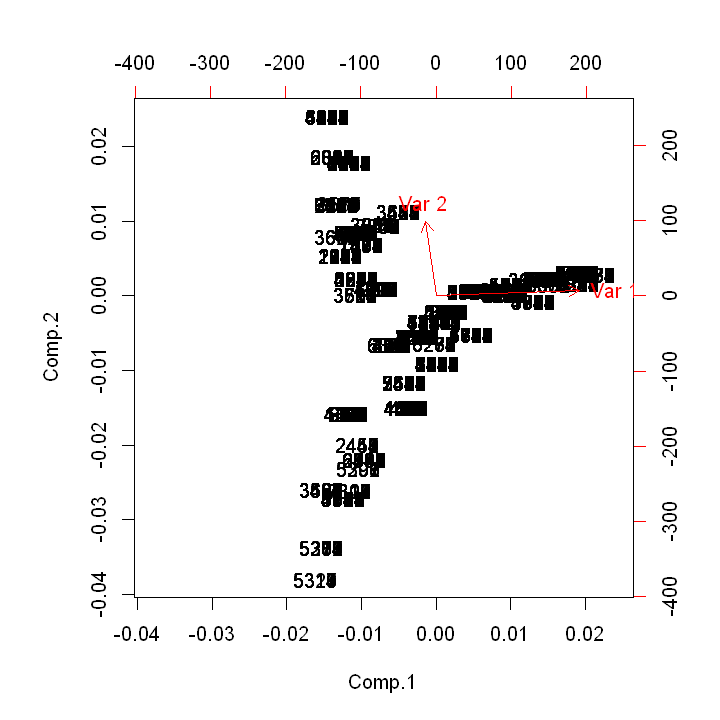

In [46]:
soilTypeBal.3.NA <- apply(soilTypeBal.3, 1, anyNA)
soilTypeBal.3.pca <- princomp(soilTypeBal.3[!soilTypeBal.3.NA, ])
options(repr.plot.width = 6, repr.plot.height = 6)
biplot(soilTypeBal.3.pca)

### Yield record

__Maximum yield per trial__: `rdt_max` stores the maximal yield per trial, for later data filtering. If yield was not recorded, `rdt_max` stores `NA`.

In [64]:
rdt_max <- rep(NA, nrow(data_df)) # max yield per trial (empty vector)

for (i in 1:nlevels(factor(data_df$NoEssai))) {
  filtre <- data_df$NoEssai == levels(factor(data_df$NoEssai))[i] # filter for test i
  rdt_max[filtre] <- ifelse(is.na(data_df$RendVendable[filtre]), NA, 
                            max(data_df$RendVendable[filtre], na.rm = TRUE))
}
rdt_max[!is.finite(rdt_max)] <- NA
data_df$RendVendableMaxParEssai <- rdt_max

__Tuber size__ proportions

In [48]:
data_df <- data_df %>%
                mutate(pcGros = RendGros*100/RendVendable,              # Large size
                      pcMoy = RendMoy*100/RendVendable,                 # Medium size
                      pcPetit = RendPetit*100/RendVendable)             # Small size
t(apply(data_df %>% select(pcGros, pcMoy, pcPetit) %>% head(), 1, sum))

1,2,3,4,5,6
100,100,100,100,100,100


In [49]:
prop_col <- c('pcGros', 'pcMoy', 'pcPetit')
yieldparts <- data_df %>% select(pcGros, pcMoy, pcPetit)
zComp <- cmultRepl(data_df[complete.cases(yieldparts), prop_col], method = "GBM", output = "prop", delta = 0.65)
colnames(zComp) <- c('zGros', 'zMoy', 'zPetit')

No. corrected values:  1322 


In [50]:
zComp <- zComp %>% mutate(NoEssai = data_df$NoEssai[complete.cases(yieldparts)],
                         NoBloc = data_df$NoBloc[complete.cases(yieldparts)],
                         NoTraitement = data_df$NoTraitement[complete.cases(yieldparts)])
head(zComp)

zGros,zMoy,zPetit,NoEssai,NoBloc,NoTraitement
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
0.1892980,0.6024166,0.20828539,1,1,1
0.4430038,0.4351702,0.12182604,1,1,2
0.3945892,0.4140548,0.19135599,1,1,3
0.4702467,0.4325109,0.09724238,1,1,4
0.4856669,0.4129353,0.10139777,1,1,5
0.4653202,0.4182833,0.11639649,1,1,6


In [52]:
data_df <- data_df %>% left_join(zComp, by = keys_col)
yieldparts <- data_df %>% select(zGros, zMoy, zPetit)

Tuber size sequential binary partition (__sbp__):

In [53]:
sbp <- matrix(c( 1, -1, -1,             # [Medium, Small | Large]
                 0, 1, -1),             # [Small | Medium]
             byrow = TRUE, ncol = 3)
colnames(sbp) <- c('Large', 'Medium', 'Small')

In [54]:
yieldComp <- acomp(yieldparts)
yieldBal2 <- ilr(yieldComp, V = gsi.buildilrBase(t(sbp)))
yieldBal2 <- ilrNA(yieldComp, sbp, yieldBal2) # ilrNA(acomp(data), matrix sbp, ilr transformed object)

In [55]:
data_df$tsizeMS_L <- yieldBal2[, 1] # ilr1 [Large, Small | Medium] qui msximisé privilégie la Table
data_df$tsizeS_M <- yieldBal2[, 2] # ilr2 [Large | Small] qui msximisé privilégie la Transformation

This __processed__ data frame is saved as `balanced_potato_df`.

In [68]:
write_csv(data_df, 'output/balanced_potato_df.csv')